In [1]:
# d6592
# The actual code to generate some Bach

bar_length = 96
bars = 8
NOTES_PER_OCTAVE = 12
MIDI_INPUTS = 128  # Length the rolls pitches must be
MIDDLE_C = 64
num_notes_above_c = int(1.8 * NOTES_PER_OCTAVE)  # Centered around C, how many on either side
num_notes_below_c = int(2.5 * NOTES_PER_OCTAVE)
num_pitches = num_notes_above_c + num_notes_below_c

lookback = 96*4  # How far back can the model look? (Roughly four bars)
step = 4  # Skip through it a bit
generated_length = bar_length * 4

import numpy as np
import pypianoroll as pr
from pypianoroll import Track, Multitrack
%matplotlib inline
import matplotlib.pyplot as plt 
import os

def display_pianoroll(roll, title='Piano Roll'):
    plt.figure(figsize=(8,6))
    plt.matshow(roll, fignum=1, aspect='auto', cmap='plasma')
    plt.xlabel('Pitch')
    plt.ylabel('Time')
    plt.title(title)
    plt.show()


Found 36 files: ['1080-c12.mid', 'jsbwv552.mid', 'bwv539_2.mid', 'bwv582.mid', 'bwv539_1.mid', 'bwv525-1.mid', 'jsbwv541.mid', '1080-c01.mid', 'bwv525-2.mid', 'jsbwv543.mid', 'bwv525-3.mid', '1080-c02.mid', 'bwv1028.mid', 'bwv1029.mid', '1080c02b.mid', 'bwv537.mid', 'jsbwv533.mid', 'jsbwv532.mid', 'bwv686.mid', 'bwv653.mid', 'bwv733.mid', 'bwv552p.mid', 'bwv552f.mid', 'bwv1027.mid', 'bwv539.mid', 'bwv530-2.mid', 'bwv529-3.mid', 'bwv529-2.mid', 'bwv588.mid', 'bwv530-3.mid', 'bwv530-1.mid', 'bwv529-1.mid', 'goldberg.mid', 'jsbwv549.mid', 'bwv0541p.mid', 'bwv0541f.mid']
Lower bound 34.
Upper bound 85.
Num pitches 51
1080-c12.mid input shape: (6432, 128)
...Refined down 77 dimensions with 0 note loss.
...Loss of 0.0 %
...Output shape: (6432, 51)
jsbwv552.mid input shape: (36624, 128)
...Refined down 77 dimensions with 3536 note loss.
...Loss of 3.05 %
...Output shape: (36624, 51)
extended output shape (43056, 51)


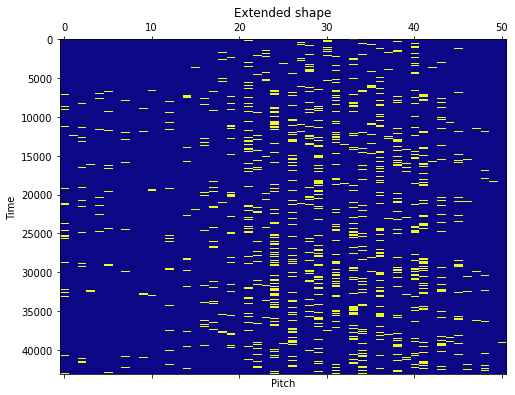

In [2]:
root = '/Users/James/PycharmProjects/deep-learning/music/lstm-generation-bach'
#root = '/home/ubuntu/deep-learning/music/lstm-generation-bach'
midi_dir = os.path.join(root, 'midi')

fnames = os.listdir(midi_dir)
print('Found', len(fnames),'files:', fnames)

print('Lower bound %s.' % (MIDDLE_C-num_notes_below_c))
print('Upper bound %s.' % (MIDDLE_C+num_notes_above_c))
print('Num pitches', num_pitches)

data = []
total_length = 0

for fname in fnames[:2]:  # Only get first 3
    file = os.path.join(midi_dir, fname)
    piano_multitrack = pr.Multitrack(file)
    
    piano_multitrack.trim_trailing_silence()
    piano_multitrack.binarize()
    
    pianoroll = piano_multitrack.get_merged_pianoroll()
    
    #display_pianoroll(pianoroll, title='RAW')
    
    print(fname, 'input shape:', pianoroll.shape)
    
    # Adjust so that there are only the selected notes present
    refined = pianoroll[:, MIDDLE_C-num_notes_below_c:MIDDLE_C+num_notes_above_c]
    
    #display_pianoroll(refined, title='Refined')
    
    loss = np.sum(pianoroll)- np.sum(refined)
    print('...Refined down',128-num_notes_above_c-num_notes_below_c, 'dimensions with',loss , 'note loss.')
    print('...Loss of', (loss/np.sum(pianoroll)*100).__round__(2),'%')
    print('...Output shape:', refined.shape)
    
    data.append(refined)
    total_length += refined.shape[0]
    
extended = np.zeros((total_length, data[0].shape[1]), dtype='bool')
print('extended output shape', extended.shape)

index = 0
for sequence in data:
    extended[index:index+sequence.shape[0], :] = sequence
    index += sequence.shape[0]
display_pianoroll(extended, title='Extended shape')

In [3]:
# Now convert to phrases with a corresponding label
phrases = []
next_notes = []
for i in range(0, extended.shape[0]-lookback, step):
    phrases.append(extended[i:i+lookback, :])  # Get the block
    next_notes.append(extended[i+lookback, :])  # The next line

print(len(phrases), 'individual phrases.')

# Vectorisation
x = np.zeros((len(phrases), lookback, num_pitches), dtype='bool')
y = np.zeros((len(phrases), num_pitches), dtype='bool')

for i, phrase in enumerate(phrases):
    x[i, :, :] = phrase
    y[i, :] = next_notes[i]

10668 individual phrases.


In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32, input_shape=(lookback, num_pitches), return_sequences=True, dropout=0.1, recurrent_dropout=0.3))
#model.add(layers.LSTM(64, dropout=0.1, recurrent_dropout=0.3))
#model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_pitches, activation='sigmoid'))
model.summary()

model.compile(loss='mse',  # categorical_crossentropy
              optimizer=RMSprop(),
              metrics=['acc'])

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 384, 32)           10752     
_________________________________________________________________
dense_1 (Dense)              (None, 384, 51)           1683      
Total params: 12,435
Trainable params: 12,435
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from time import time
start = time()
history = model.fit(x, y,
                    epochs=10,
                    batch_size=64)
print('Saving model.')
model.save('first_try.h5')

In [ ]:
def plot_values(history):
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc)+1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b-', label='Validation acc')
    plt.title('Training accuracy')
    plt.legend()
    
    plt.figure()  # Combines the two graphs
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training loss')
    plt.legend()
    
    plt.show()

In [5]:
from keras import models
model = models.load_model('first_try.h5')
print('Loaded old model')

Loaded old model


In [8]:
def extract_music(line, temperature=0.5, threshold=None):
    if threshold is not None:
        # Adjust the music to be 1 if above the threshold, else 0
        split = line - threshold + 0.5  # Center around 0.5
        split = np.round(split, 0)
        return split
        #return np.round(split, 0)
    # Otherwise do some randomness!!
    #TODO: Add this bit
    
# Generate some music!
import random
start_index = random.randint(0, extended.shape[0]-lookback-1)
seed = extended[start_index:start_index+lookback, :]
seed = np.reshape(seed, (1, seed.shape[0], seed.shape[1]))

sampled = seed.copy()

output = np.zeros((1, generated_length+lookback, num_pitches))
output[0, :lookback, :] = seed

#sampled = np.zeros((1, lookback, num_pitches))
print(sampled.shape)

for i in range(generated_length):
    preds = model.predict(sampled, verbose=0)
    extracted = extract_music(preds, threshold=0.1)
    
    output[0,lookback+i] = extracted  # Save the work
    sampled[:, :-1] = sampled[:,1:]  # Move it over by one
    sampled[0, -1, :] = extracted  # Add it to the last row
    


(1, 384, 51)


(1, 768, 51)
(768, 128)


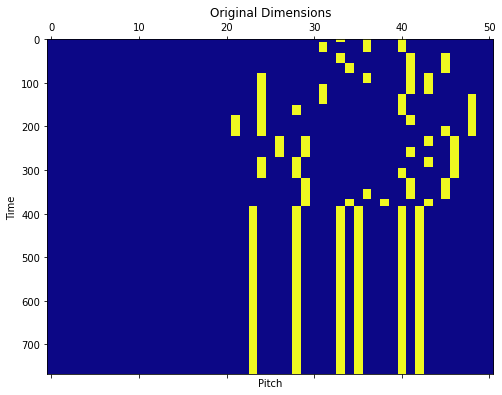

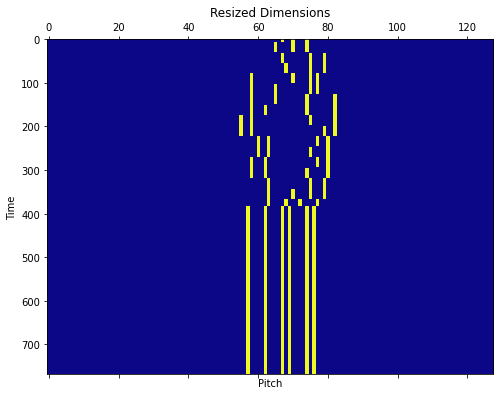

In [9]:
def process_roll(x):
    x = np.reshape(x, (x.shape[1], x.shape[2]))
    display_pianoroll(x, title='Original Dimensions')
    y = np.zeros((x.shape[0], MIDI_INPUTS))
    y[:, MIDDLE_C-num_notes_below_c:MIDDLE_C+num_notes_above_c] = x
    display_pianoroll(y, title='Resized Dimensions')
    y *= 100  # Make it a bit louder
    return y
    
def save_roll(x, fname='test.mid'):
    t = Track(pianoroll=x, program=0, is_drum=False, name='ai gen pianoroll')
    mt = Multitrack(tracks=[t], tempo=120.0)
    mt.write(fname)

test = output.copy()
print(test.shape)
test = process_roll(test)
print(test.shape)

save_roll(test)